# Reinforce  Monte Carlo Algorithm
In this notebook, you'll code The Reinforce (also called Monte Carlo Policy Gradient) algorithm  from scratch: .

Reinforce is a *Policy-based method*: a Deep Reinforcement Learning algorithm that tries **to optimize the policy directly without using an action-value function**.

More precisely, Reinforce is a *Policy-gradient method*, a subclass of *Policy-based methods* that aims **to optimize the policy directly by estimating the weights of the optimal policy using gradient ascent**.

To test its robustness, we're going to train it in Cartpole-v1 environment

## Import the packages

In [27]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym


## Check if we have a GPU
- Let's check if we have a GPU `device:cuda0`

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Agent: Playing CartPole-v1 🤖
### The CartPole-v1 environment

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

So, we start with CartPole-v1. The goal is to push the cart left or right **so that the pole stays in the equilibrium.**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

We get a reward 💰 of +1 every timestep the Pole stays in the equilibrium.

In [29]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [30]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [ 0.27718592 -2.7320774   0.2215915  -1.921128  ]


In [31]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 1


## Let's build the Reinforce Architecture
<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/reinforce.png" alt="Reinforce"/>

So we want:
- Two fully connected layers (fc1 and fc2).
- Using ReLU as activation function of fc1
- Using Softmax to output a probability distribution over actions

In [32]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # return raw logits
        return x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        logits = self.forward(state)
        m = Categorical(logits=logits)  # pass logits directly
        action = m.sample()
        return action.item(), m.log_prob(action)

- Since **we want to sample an action from the probability distribution over actions (i.e., Stochastic policy)**, we can't use `action = np.argmax(m)` since it will always output the action that have the highest probability.

- We need to replace with `action = m.sample()` that will sample an action from the probability distribution P(.|s)

### Let's build the Reinforce Training Algorithm
This is the Reinforce algorithm pseudocode:
<img src="https://github.com/malkiAbdelhamid/Advanced-Deep-Learning-2023-2024-esisba/blob/master/lab3_Policy_Gradient/Reinforce_algo.png?raw=true" alt="Policy gradient pseudocode"/>

# Building the parts of our algorithm #
The main steps for building a Reinforce Algo are:
1. Generates a trajectory (Line 3)
2. Compute the discounted returns (Lines 4 & 5)
3. Standardization of the returns
4. Calculate current loss (objective function $J(\theta)$) and estimate the gradient (Lines 6 & 7)
5. Update parameters (Line 8)



### Line 3 of pseudocode
Based on the policy, the method **generate_trajectory(policy, max_t)** generates a trajectory and return two lists:
  - saved_log_probs: the log probability of each action in the trajectory
  - rewards: the list of the obtained rewards

In [ ]:
def generate_trajectory(policy, env, max_t):
    saved_log_probs = []
    rewards = []
    state, _ = env.reset()

    for t in range(max_t):
        action, log_prob = policy.act(state)
        saved_log_probs.append(log_prob)
        next_state, reward, done, _, _ = env.step(action)
        rewards.append(reward)
        state = next_state
        if done:
            break

    return saved_log_probs, rewards

 ### Lines 4 & 5 of pseudocode
 the method **computer_cumulative_reward(rewards,max_t,gamma)** Compute the discounted returns at each timestep, as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

In [34]:
def compute_cumulative_reward(rewards, gamma):
    returns = deque()
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.appendleft(G)
    return torch.tensor(returns, dtype=torch.float32, device=device)

### standardization of the returns
- is employed to make training more stable


In [35]:
def returns_standardization(returns, device='cpu'):
    eps = np.finfo(np.float32).eps.item()  # tiny value to avoid division by zero
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    return returns

 ### Line 6, 7 & 8 of pseudocode
**why do we minimize the loss**? You talked about Gradient Ascent not Gradient Descent?

- We want to maximize our utility function $J(\theta)$ but in PyTorch like in Tensorflow it's better to **minimize an objective function.**
    - So let's say we want to reinforce action 3 at a certain timestep. Before training this action P is 0.25.
    - So we want to modify $\theta$ such that $\pi_\theta(a_3|s; \theta) > 0.25$
    - Because all P must sum to 1, max $\pi_\theta(a_3|s; \theta)$ will **minimize other action probability.**
    - So we should tell PyTorch **to min $1 - \pi_\theta(a_3|s; \theta)$.**
    - This loss function approaches 0 as $\pi_\theta(a_3|s; \theta)$ nears 1.
    - So we are encouraging the gradient to max $\pi_\theta(a_3|s; \theta)$

In [36]:
def compute_loss_and_train_policy(optimizer, saved_log_probs, returns):
    policy_loss = []
    for log_prob, G in zip(saved_log_probs, returns):
        policy_loss.append(-log_prob * G)
    policy_loss = torch.cat(policy_loss).sum()
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

## Merge all functions into the reinforce method ##

You will now see how the overall **Reinforce Algo** is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [37]:
import numpy as np
from collections import deque

def reinforce(policy, env, optimizer, n_training_episodes, max_t, gamma, print_every=10):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs, rewards = generate_trajectory(policy, env, max_t)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = compute_cumulative_reward(rewards, gamma)
        # Normalize returns for stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        compute_loss_and_train_policy(optimizer, saved_log_probs, returns)

        if i_episode % print_every == 0:
            print(f"Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}")

    return scores


##  Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters (and should 😉)

In [44]:
# Hyperparameters
cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}


In [45]:

# Create policy and place it on device
cartpole_policy = Policy(
    cartpole_hyperparameters["state_space"],
    cartpole_hyperparameters["action_space"],
    cartpole_hyperparameters["h_size"]
).to(device)

# Create optimizer
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])


In [46]:
scores = reinforce(
    cartpole_policy,           # use the correct policy variable
    env,
    cartpole_optimizer,        # use the correct optimizer
    n_training_episodes=cartpole_hyperparameters["n_training_episodes"],
    max_t=cartpole_hyperparameters["max_t"],
    gamma=cartpole_hyperparameters["gamma"],
    print_every=20
)

Episode 20	Average Score: 16.50
Episode 40	Average Score: 26.90
Episode 60	Average Score: 50.17
Episode 80	Average Score: 65.85
Episode 100	Average Score: 106.44
Episode 120	Average Score: 272.25
Episode 140	Average Score: 463.27
Episode 160	Average Score: 637.11
Episode 180	Average Score: 764.99
Episode 200	Average Score: 734.03
Episode 220	Average Score: 657.80
Episode 240	Average Score: 627.30
Episode 260	Average Score: 561.27
Episode 280	Average Score: 597.73
Episode 300	Average Score: 774.93
Episode 320	Average Score: 783.53
Episode 340	Average Score: 723.09
Episode 360	Average Score: 617.65
Episode 380	Average Score: 464.08
Episode 400	Average Score: 302.59
Episode 420	Average Score: 290.82
Episode 440	Average Score: 377.09
Episode 460	Average Score: 552.64
Episode 480	Average Score: 719.29
Episode 500	Average Score: 880.78
Episode 520	Average Score: 991.07
Episode 540	Average Score: 992.05
Episode 560	Average Score: 848.05
Episode 580	Average Score: 818.73
Episode 600	Average Sc

In [47]:
scores= pd.Series(scores, name="scores_REINFORCE")
scores.describe()

,scores_REINFORCE
count,1000.000000
mean,725.508000
std,383.465602
min,9.000000
25%,284.000000
50%,1000.000000
75%,1000.000000
max,1000.000000


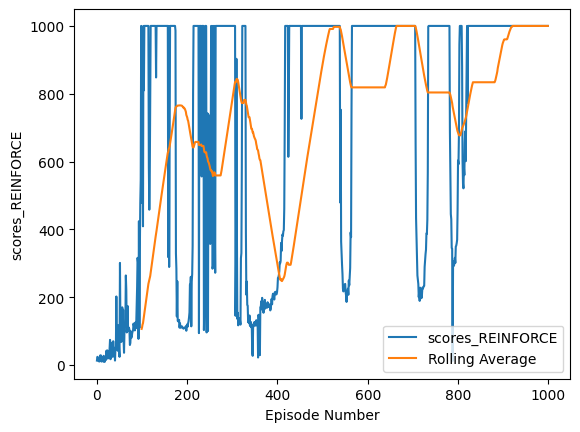

In [48]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="scores_REINFORCE")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_REINFORCE")